In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline
import cv2 as cv
from matplotlib.patches import Rectangle
import tensorflow as tf
import os
import imghdr

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

#Prepare and Split the image

In [4]:
data_dir = "..//Dataset/train" #os.path.join(PROJECT_PATH, DATA_DIR_NAME)
data_dir

'..//Dataset/train'

In [5]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [6]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [7]:
#Kích thước sample, image_dataset_from_directory sẽ nén ảnh về size này để đúng 1 chuẩn
data = tf.keras.utils.image_dataset_from_directory( data_dir)

Found 16002 files belonging to 2 classes.


In [8]:
# Get the class names
class_names = data.class_names

# Print the class names
print(class_names)

['fake', 'real']


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

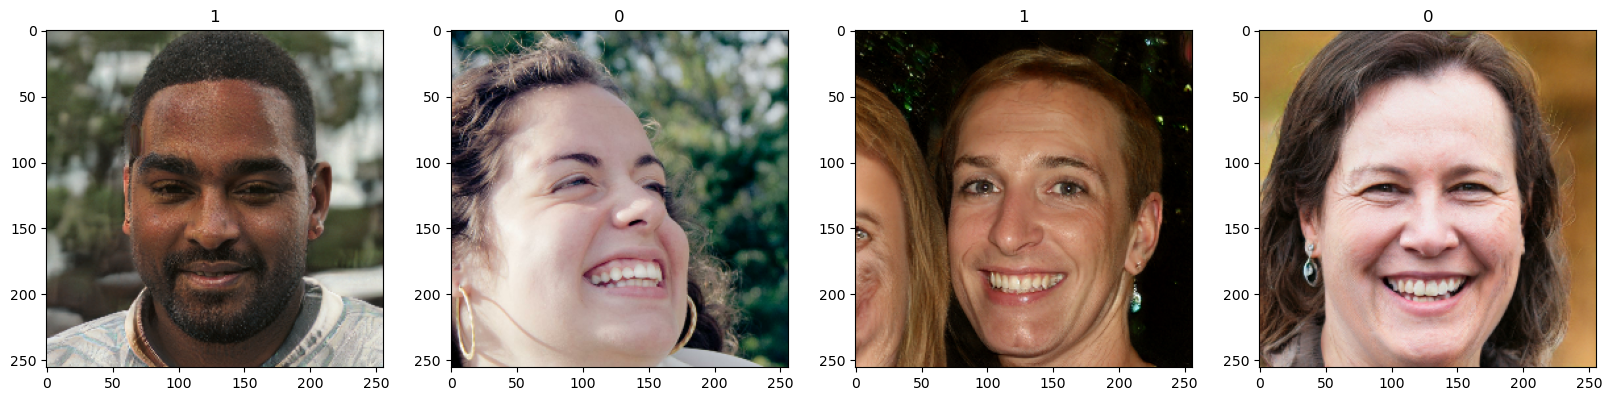

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][12:16]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Use flow_directory to automate load and label image

In [13]:
# train_folder = '/content/drive/MyDrive/Learning/dataset_02/DeepFake/faces/Frequency/Faces-HQ/train'
# valid_folder = '/content/drive/MyDrive/Learning/dataset_02/DeepFake/faces/Frequency/Faces-HQ/validation'

In [14]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# # Add our data-augmentation parameters to ImageDataGenerator
# train_datagen = ImageDataGenerator(rescale = 1./255.,
#                                    rotation_range = 40,
#                                    width_shift_range = 0.2,
#                                    height_shift_range = 0.2,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

# # Note that the validation data should not be augmented!
# validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

# # Flow training images in batches of 20 using train_datagen generator
# train_generator = train_datagen.flow_from_directory(train_folder,
#                                                     batch_size = 20,
#                                                     class_mode = 'binary',
#                                                     target_size = (150, 150))

# # Flow validation images in batches of 20 using test_datagen generator
# validation_generator =  validation_datagen.flow_from_directory( valid_folder,
#                                                           batch_size  = 20,
#                                                           class_mode  = 'binary',
#                                                           target_size = (150, 150))

# SCALE DATA

In [16]:
data = data.map(lambda x,y: (x/255, y))

# SPLIT DATA

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

350

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Building Model

## Testing using InceptionNet

In [20]:
# wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#     -O ./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [21]:
# import requests

# url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
# filename = "./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# try:
#     response = requests.get(url, stream=True)
#     response.raise_for_status()

#     with open(filename, "wb") as f:
#         for chunk in response.iter_content(chunk_size=8192):
#             f.write(chunk)

#     print(f"Downloaded {filename} successfully.")
# except requests.exceptions.RequestException as e:
#     print(f"Error: {e}")


Downloaded ./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 successfully.


In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [2]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape = (256, 256, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)


In [3]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_normalizati

Lock các layer của pretrained model

In [4]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [5]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_normalizati

Train lại từ layer mixed7, Ctrl F cái summary để coi nó ở đâu

In [6]:
last_layer = pre_trained_model.get_layer('mixed7')

In [7]:
last_output = last_layer.output
last_output

<KerasTensor: shape=(None, 14, 14, 768) dtype=float32 (created by layer 'mixed7')>

In [9]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)

model = Model( pre_trained_model.input, x)



In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_normalization[0][0

In [ ]:
model.compile(optimizer = RMSprop(lr=0.01),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [30]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
# Train the model with early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

history = model.fit(
            train,
            validation_data = val,
            epochs = 10,
            validation_steps = 20,
            verbose=1,
            callbacks=[tensorboard_callback])

Epoch 1/10
350/350 [==============================] - 935s 3s/step - loss: 1.0642 - acc: 0.7456 - val_loss: 0.2989 - val_acc: 0.8625
Epoch 2/10
350/350 [==============================] - 892s 3s/step - loss: 0.2963 - acc: 0.8826 - val_loss: 0.2778 - val_acc: 0.8859
Epoch 3/10
350/350 [==============================] - 933s 3s/step - loss: 0.1687 - acc: 0.9326 - val_loss: 0.3332 - val_acc: 0.8719
Epoch 4/10
350/350 [==============================] - 835s 2s/step - loss: 0.1250 - acc: 0.9516 - val_loss: 0.1497 - val_acc: 0.9344
Epoch 5/10
350/350 [==============================] - 842s 2s/step - loss: 0.0834 - acc: 0.9710 - val_loss: 0.1402 - val_acc: 0.9547
Epoch 6/10
350/350 [==============================] - 883s 3s/step - loss: 0.0618 - acc: 0.9781 - val_loss: 0.1854 - val_acc: 0.9500
Epoch 7/10
350/350 [==============================] - 940s 3s/step - loss: 0.0579 - acc: 0.9807 - val_loss: 0.2095 - val_acc: 0.9453
Epoch 8/10
350/350 [==============================] - 959s 3s/step - 

In [34]:
from keras.models import load_model

# Save the model to an HDF5 file
model.save("models/inception_v3_trainedModel.h5")


# 8. Plot performance

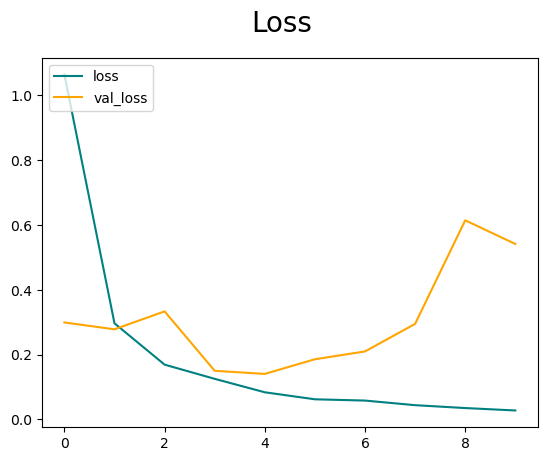

In [35]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

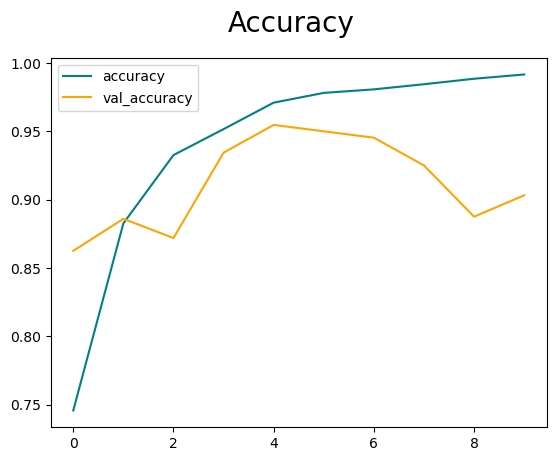

In [38]:
fig = plt.figure()
plt.plot(history.history['acc'], color='teal', label='accuracy')
plt.plot(history.history['val_acc'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [39]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [40]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [41]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 1s/step


In [42]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.97324413, shape=(), dtype=float32) tf.Tensor(0.73951715, shape=(), dtype=float32) tf.Tensor(0.861875, shape=(), dtype=float32)


In [1]:
from keras.models import load_model

# Load the model from the HDF5 file
loaded_model = load_model("./models/inception_v3_trainedModel.h5")

# Now you can use 'loaded_model' for predictions or deployment


# 10. Test

In [2]:
import cv2 as cv

In [3]:
import matplotlib.pyplot as plt

In [4]:
def OutputLabel(yHat):
    # Get the predicted class index (0 or 1 in binary classification)
    predicted_class_index = int(yhat > 0.5)

    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_index]

    # Print the result
    print(f'Predicted class is {predicted_class_name}')

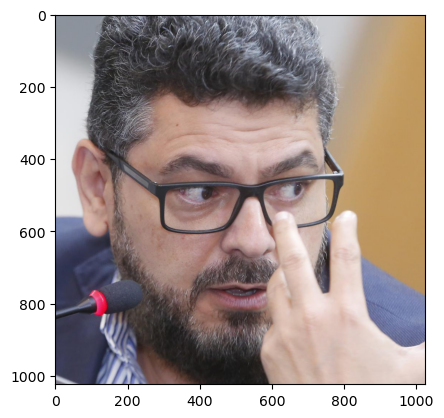

In [48]:
import matplotlib.image as mpimg

image = mpimg.imread("../Dataset/validation/real/8001.jpg")
plt.imshow(image)
plt.show()

In [49]:
import numpy as np

In [51]:
resize = tf.image.resize(image, (256, 256))
yhat = model.predict(np.expand_dims(resize / 255, 0))

1/1 [==============================] - 1s 1s/step


In [52]:
yhat

array([[1.]], dtype=float32)

In [53]:
OutputLabel(yhat)

Predicted class is real


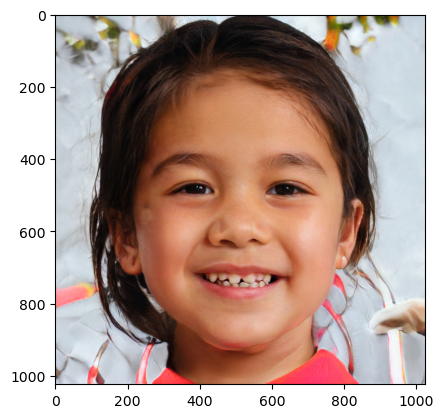

In [54]:
import matplotlib.image as mpimg

image = mpimg.imread("../Dataset/validation/fake/8001.jpg")
plt.imshow(image)
plt.show()

In [56]:
resize = tf.image.resize(image, (256, 256))
yhat = model.predict(np.expand_dims(resize / 255, 0))
OutputLabel(yhat)

1/1 [==============================] - 0s 135ms/step
Predicted class is fake


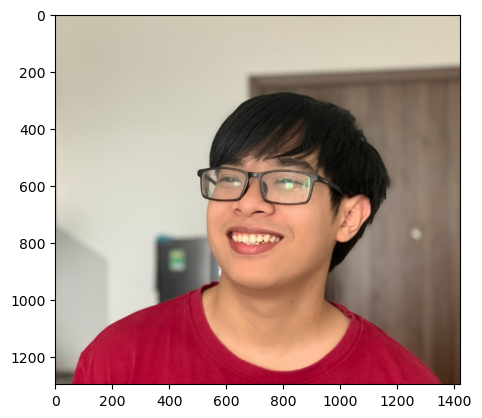

In [6]:
import matplotlib.image as mpimg

image = mpimg.imread("../Dataset/z3886573345310_ec4b43b9d459b1819ecab0232adb3740.jpg")
plt.imshow(image)
plt.show()

In [11]:
class_names =  ['fake', 'real']

In [12]:
import tensorflow as tf
import numpy as np
resize = tf.image.resize(image, (256, 256))
yhat = loaded_model.predict(np.expand_dims(resize / 255, 0))
OutputLabel(yhat)

1/1 [==============================] - 0s 117ms/step
Predicted class is real
